# Reviewer recommendation in GitHub

### 1. Create Dataset

In [1]:
from github import Github
import datetime
import pandas as pd
import numpy as np
import networkx as nx
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import math
import random
import operator

In [2]:
# Specify your own Github access token here
ACCESS_TOKEN = 'XXXXXXXXXXXX'

# Specify a username and repository of interest for that user
USER = 'tensorflow'
REPO = 'tensorflow'

client = Github(ACCESS_TOKEN, per_page=100)

In [87]:
user = client.get_user(USER)
repo = user.get_repo(REPO)

In [88]:
pull_requests = repo.get_pulls(state='closed', sort="created", direction="desc")

In [89]:
def extract_comments(pr):
    comments = [[pr.number, pr.user.login, pr.created_at, c.user.login, c.created_at] for c in pr.get_comments()]
    return pd.DataFrame(comments,columns=['pull_request_id', 'contributor', 'pull_request_created_at', 'reviewer', 'review_comment_created_at'])

In [90]:
# Get pull requests
page_size = 10
df = pd.DataFrame([],columns=['pull_request_id', 'contributor', 'pull_request_created_at', 'reviewer', 'review_comment_created_at'])
for i in range(page_size):
    for pr in pull_requests.get_page(i):
        df_temp = extract_comments(pr)
        df = pd.concat([df_temp, df]).reset_index(drop=True)

In [8]:
# Save pull requests as a csv file
df.to_csv('tensorflow.csv', index=False)

In [91]:
print("Number of comments: ", df.shape[0])
print("Number of pull requests: ", df["pull_request_id"].unique().size)
print("Number of unique reviewer: ", df["reviewer"].unique().size)

Number of comments:  1217
Number of pull requests:  177
Number of unique reviewer:  106


In [92]:
# Average comments on pull requests
print("Average comments on pull requests:", df.groupby('pull_request_id').size().mean())

Average comments on pull requests: 6.875706214689266


In [84]:
# Average time for first comment
df_first_comment = df[df.groupby(['pull_request_id'])['review_comment_created_at'].transform(min) == df['review_comment_created_at']]
first_comment = ((pd.to_datetime(df_first_comment['review_comment_created_at']) - pd.to_datetime(df_first_comment['pull_request_created_at'])).dt.total_seconds() / 60 / 60).mean()
print("Average time for the first comment: ", first_comment)

Average time for the first comment:  238.87978499686125


### 2. Train/Test Split

In [ ]:
# Read from csv
# df = pd.read_csv('tensorflow.csv')

In [93]:
df = df.query("reviewer != contributor") 
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_test = df[~msk]

In [94]:
print("[Train] Number of comments: ", df_train.shape[0])
print("[Train] Number of pull requests: ", df_train["pull_request_id"].unique().size)
print("[Train] Number of unique reviewer: ", df_train["reviewer"].unique().size)
print("-------------------------------------------------------")
print("[Test] Number of comments: ", df_test.shape[0])
print("[Test] Number of pull requests: ", df_test["pull_request_id"].unique().size)
print("[Train] Number of unique reviewer: ", df_test["reviewer"].unique().size)

[Train] Number of comments:  623
[Train] Number of pull requests:  160
[Train] Number of unique reviewer:  57
-------------------------------------------------------
[Test] Number of comments:  152
[Test] Number of pull requests:  82
[Train] Number of unique reviewer:  33


### 3. Create Comment Network

Adapted from the following article: 
[Reviewer Recommendation for Pull-Requests in GitHub](https://yuyue.github.io/res/paper/IST2016.pdf)


In [111]:
def calculate_weight_matrix(df_train):
    weight_matrix = defaultdict(dict)
    start_time = min(df_train["review_comment_created_at"])
    end_time = max(df_train["review_comment_created_at"])
    lambda_factor = 0.8

    for _, pr_comment_group in df_train.groupby("pull_request_id"):
        for reviewer, reviewer_comment_group in pr_comment_group.groupby("reviewer"):
            for n, comment in reviewer_comment_group.iterrows():
                comment_time = comment['review_comment_created_at']
                t = ((comment_time - start_time) / (end_time - start_time))
                if comment['contributor'] in weight_matrix.keys() and comment['reviewer'] in weight_matrix[comment['contributor']].keys():
                    weight_matrix[comment['contributor']][comment['reviewer']] += math.pow(lambda_factor,n) * t
                else:
                    weight_matrix[comment['contributor']][comment['reviewer']] = math.pow(lambda_factor,n) * t 

    return weight_matrix

109


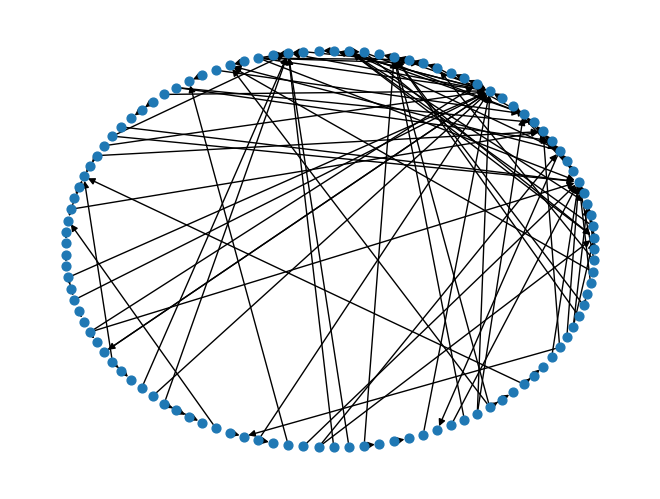

In [112]:
weight_matrix = calculate_weight_matrix(df_train)

G = nx.DiGraph()

for contributor in weight_matrix.keys():
    for reviewer in weight_matrix[contributor].keys():
        G.add_edge(contributor, reviewer, weight=weight_matrix[contributor][reviewer])

print(G.number_of_nodes())


nx.draw(G, pos=nx.circular_layout(G), node_size=40, with_labels = False)
plt.savefig("graph.png")
plt.show()

### 4. Community Detection

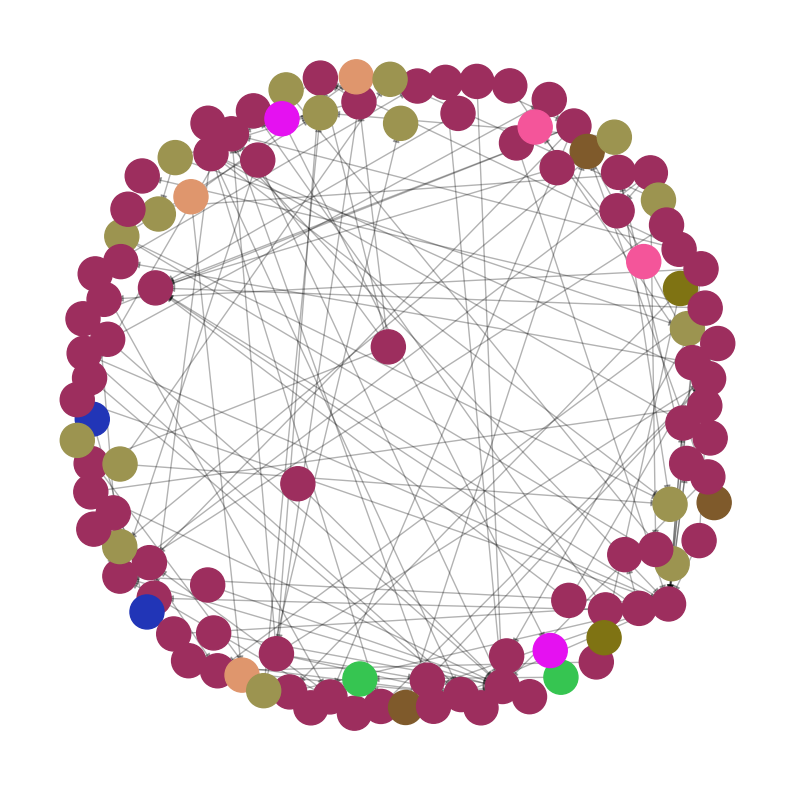

In [113]:
from networkx.algorithms.community.centrality import girvan_newman

# https://networkx.guide/algorithms/community-detection/girvan-newman/
communities = girvan_newman(G)

node_groups = []
for com in next(communities):
  node_groups.append(list(com))

number_of_colors = len(node_groups)

colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

color_map = []
for node in G:
  for i, node_group in enumerate(node_groups):
    if node in node_group:
        color_map.append(colors[i])
 
pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=600, cmap=plt.cm.RdYlBu, node_color=color_map)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.show(G)

### 5. Reviwer Recommendation

In [114]:
# Top-k Recommendation

min_community_size = 2 # Omit the extremely small communities involving less than 2 nodes
top_k = 3

y_test, y_predicted = {}, {}

for id, pr_comment_group in df_test.groupby("pull_request_id"):
    y_test[id] = pr_comment_group['reviewer'].unique()
    contributor = pr_comment_group.iloc[0]['contributor']
    if G.has_node(contributor) and G.out_degree(contributor) > 0:
        candidates = sorted(G[contributor].items(), key=lambda edge: edge[1]['weight'], reverse=1)
        y_predicted[id] = [c[0] for c in candidates[:top_k]]
    else:
        # Community detection
        communities = [group for group in node_groups if len(group) > min_community_size]
        communities.sort(key=len, reverse=True)
        candidates = [max(community, key=lambda c: G.in_degree(c)) for community in communities]
        y_predicted[id] = candidates[:top_k]

In [115]:
# Evaluation
# Precision = TruePositives / (TruePositives + FalsePositives)
# Recall = TruePositives / (TruePositives + FalseNegatives)

precision, recall = {}, {}

for pr in y_predicted.keys():
    TP, FP, FN = 0, 0, 0
    for p in y_predicted[pr]:
        if p in y_test[pr]:
            TP += 1
        else:
            FP += 1
    FN = len(y_test[pr]) - TP
    precision[pr] = TP / (TP + FP)
    recall[pr] = TP / (TP + FN)

precision_avg = sum(precision.values()) / float(len(precision))
recall_avg = sum(recall.values()) / float(len(recall))

print('precision: ', precision_avg, 'recall: ', recall_avg)

precision:  0.4343334797277756 recall:  0.8958333333333334
